Import dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import kruskal, probplot


Upload data using YahooFinance:

In [2]:
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    data = data.ffill()
    return data['Adj Close']


Calculate daily returns of an asset:

In [3]:
def calculate_daily_returns(adj_close):
    return adj_close.pct_change().dropna()


Depict asset returns as a line chart:

In [4]:
def plot_prices(adj_close, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(adj_close)
    plt.title(f'{ticker} Price Trend')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.show()


Compute mean & standrard deviation needed for the next steps:

In [5]:
def descriptive_statistics(daily_returns):
    mean_return = daily_returns.mean()
    std_dev_return = daily_returns.std()
    return mean_return, std_dev_return

Compute logarithmic returns and build histogramm and Q-Q plot:

In [6]:
def plot_log_returns(adj_close):
    log_returns = np.log(adj_close / adj_close.shift(1)).dropna()
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(log_returns, bins=60, density=True, edgecolor='black')
    plt.title('Histogram of Log Returns')
    plt.subplot(1, 2, 2)
    probplot(log_returns, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Log Returns')
    plt.tight_layout()
    plt.show()
    return log_returns

Conduct and depict seasonal decomposition using seasonal_decompose function:

In [7]:
def seasonal_decomposition(adj_close):
    result = seasonal_decompose(adj_close, model='multiplicative', period=30)
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(result.observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(result.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(result.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(result.resid)
    plt.title('Residual')
    plt.tight_layout()
    plt.show()

Provide statinarity test using Augmented Dickey Fuller Test and extract needed results:

In [8]:
def stationarity_test(daily_returns):
    adf_test = tsa.adfuller(daily_returns, autolag='AIC')
    return {
        'ADF Statistic': adf_test[0],
        'p-value': adf_test[1],
        'Critical Values': adf_test[4]
    }


Build an Autocorrelation plot:

In [9]:
def autocorrelation_plot(daily_returns):
    plt.figure(figsize=(14, 7))
    plot_acf(daily_returns)
    plt.title('ACF of Daily Returns')
    plt.show()


Based on the stationarity and seasonality(depends on the time-series, one might need to conduct 1 or 2 level differencing),
conduct SARIMA model forecasting of an asset:

In [10]:
def sarima_forecast(adj_close, periods=6):
    weekly_data = adj_close.resample('ME').last().dropna()
    weekly_data = weekly_data.asfreq('ME')
    model = sm.tsa.SARIMAX(weekly_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit()
    forecast = results.get_forecast(steps=periods)
    forecast_mean = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_data, label='Observed')
    plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='red')
    plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    return forecast_mean


Build a simlation of future prices using Monte-Carlo method and depict them as line chart and then histogramm for clearer visualisation:

In [11]:
def monte_carlo_simulation(S0, mu, sigma, T, N, num_simulations):
    dt = T / N
    S = np.zeros((num_simulations, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        S[:, t] = S[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.randn(num_simulations))
    plt.figure(figsize=(10, 6))
    for i in range(num_simulations):
        plt.plot(S[i, :], lw=0.8, alpha=0.6)
    plt.title('Monte Carlo Simulation')
    plt.xlabel('Time (years)')
    plt.ylabel('Price')
    plt.show()
    plt.hist(S[:, -1], bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
    plt.title('Histogram of Simulated ETH Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    return S

Call the script:

[*********************100%%**********************]  1 of 1 completed


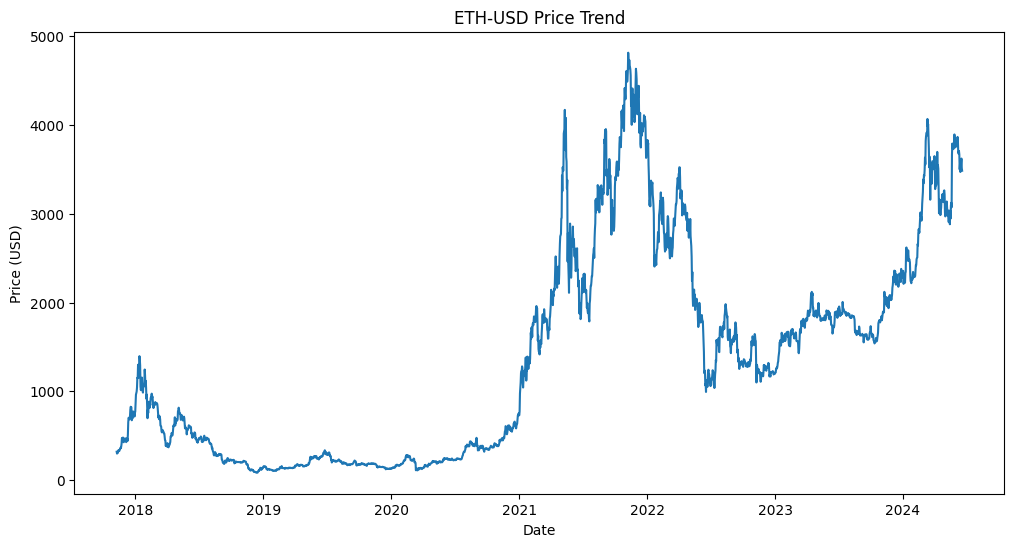

Mean of ETHUSD daily returns: 0.002087349244990698
Standard deviation of ETHUSD daily returns: 0.04654121705015931


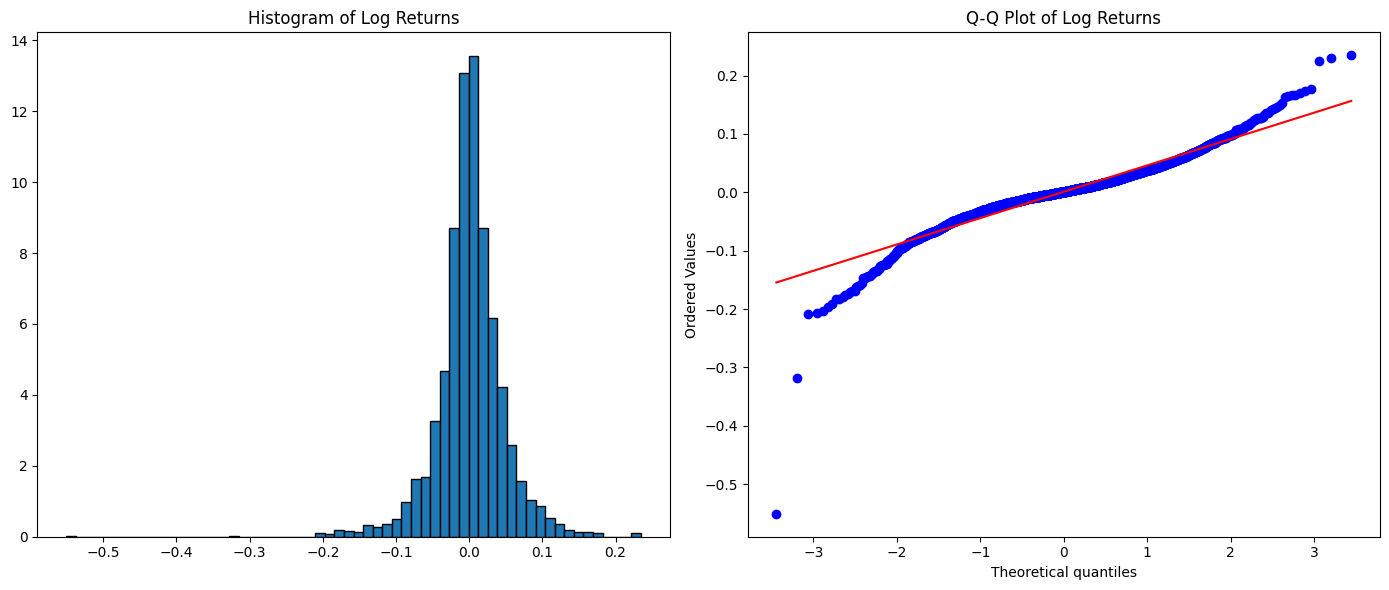

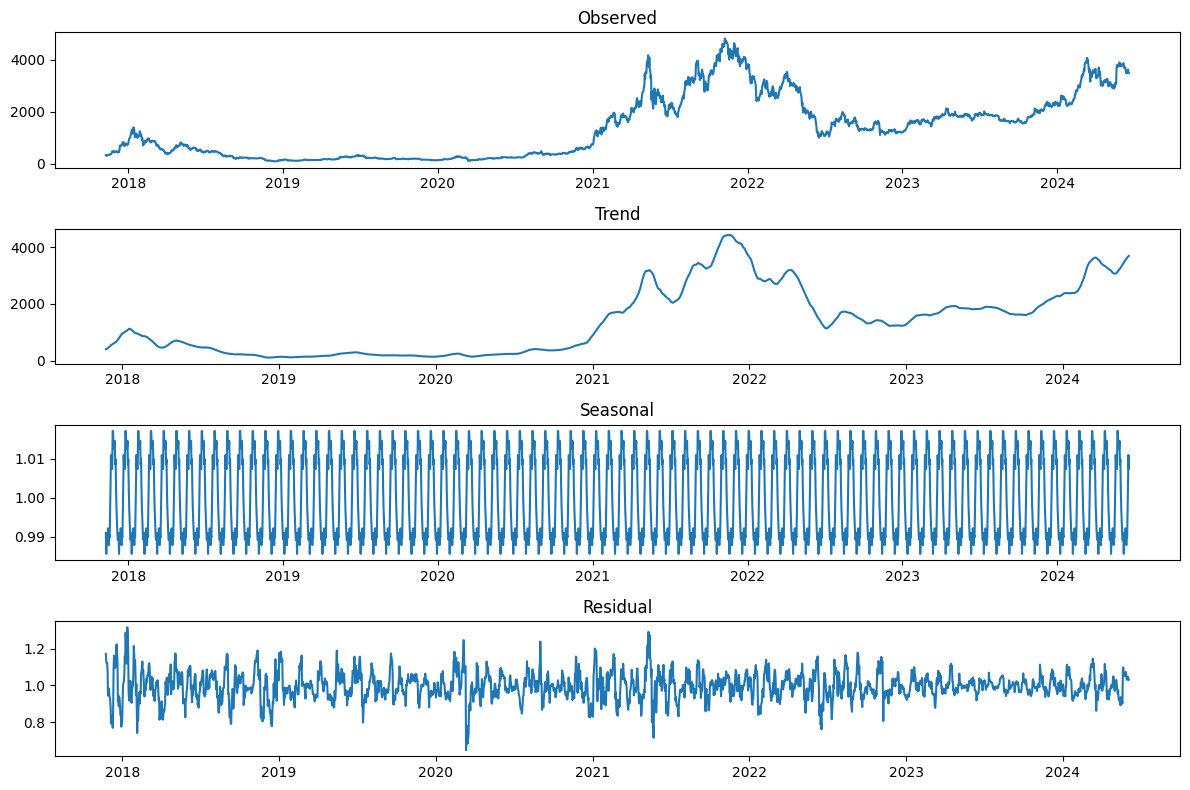

{'ADF Statistic': -14.738292175972257, 'p-value': 2.5946741841958125e-27, 'Critical Values': {'1%': -3.4330742193886445, '5%': -2.8627435243022283, '10%': -2.567410686207021}}


<Figure size 1400x700 with 0 Axes>

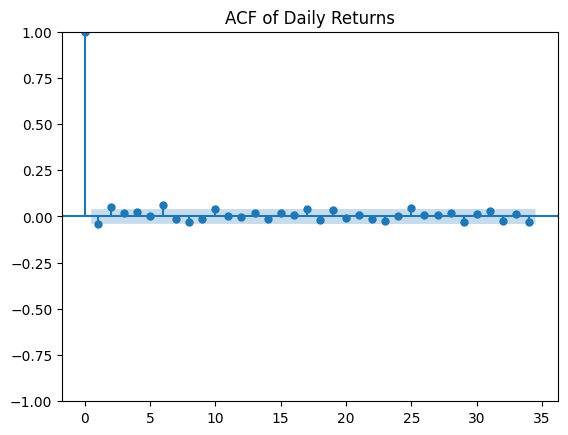

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


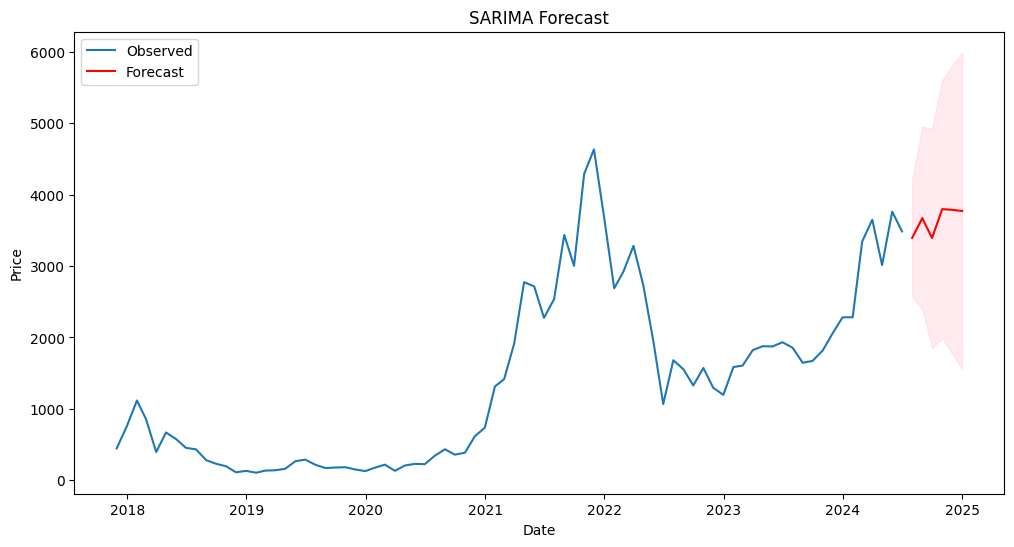

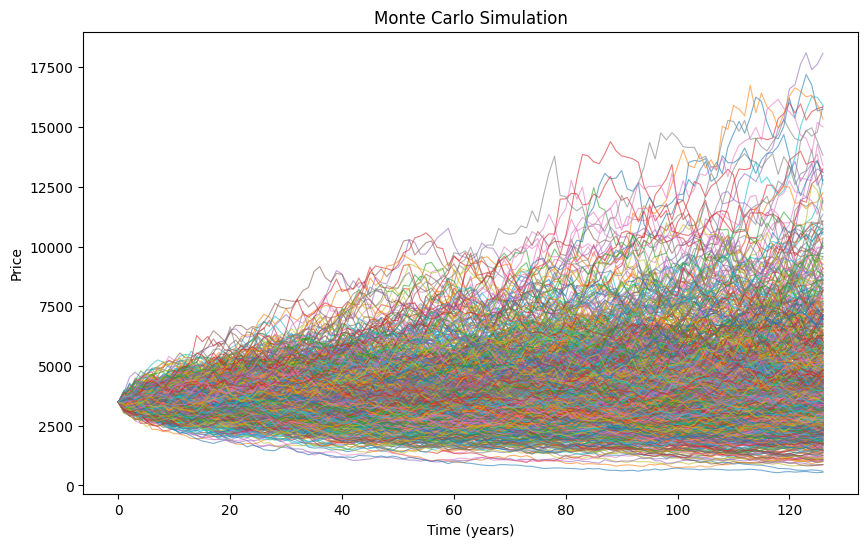

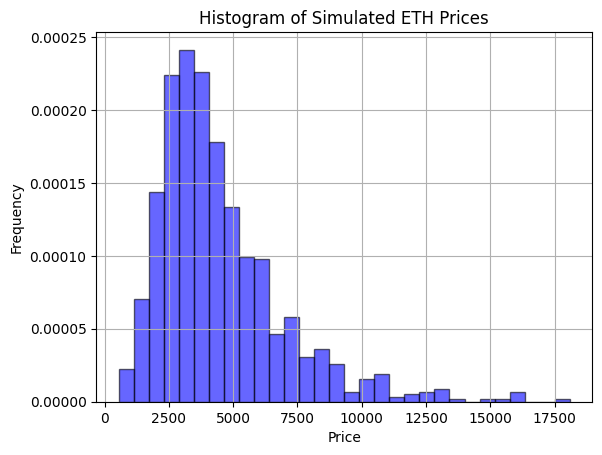

Average Simulated Price: 4458.935005772097


In [12]:
if __name__ == '__main__':
    ticker = 'ETH-USD'
    start_date = '2017-11-09'
    end_date = '2024-06-19'
    adj_close = download_data(ticker, start_date, end_date)
    daily_returns = calculate_daily_returns(adj_close)
    plot_prices(adj_close, ticker)
    mean, std = descriptive_statistics(daily_returns)
    print(f'Mean of ETHUSD daily returns: {mean}')
    print(f'Standard deviation of ETHUSD daily returns: {std}')
    log_returns = plot_log_returns(adj_close)
    seasonal_decompose = seasonal_decomposition(adj_close)
    stationarity = stationarity_test(daily_returns)
    print(stationarity)
    autocorr_plot = autocorrelation_plot(daily_returns)
    sarima_forecast(adj_close)
    S = monte_carlo_simulation(adj_close.iloc[-1], mean * 252, std * np.sqrt(252), 0.5, 126, 1000)
    print('Average Simulated Price:', S[:, -1].mean())